<font size='6'>E-commerce Analytics</font><br><br>
<font size='6'><b>Sales & Market Basket Analysis</b></font><br><br>

<font size='4'>Antonio Buzzelli</font><br>
<font size='4'>March 2023</font>

Dataset: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?sort=published


The e-commerce industry has experienced significant growth in recent years, and online sales have become an increasingly important aspect of many businesses. Analyzing sales data can help businesses understand customer behavior and identify trends, which can then be used to improve their overall sales strategies. In this notebook, we will be analyzing a sales dataset from an e-commerce company to gain insights into their sales patterns. Our analysis will cover various aspects of the data, including temporal trends and customer geographical segmentation. We will also be performing a market basket analysis to identify relationships between products and suggest strategies for improving sales. By the end of this notebook, we aim to provide a comprehensive understanding of the sales data, which can then be used to make informed decisions and drive business growth.

In [34]:
# dataframes
import numpy as np
import pandas as pd

# dataviz
import matplotlib.pyplot as plt

# hypothesis testing
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# market basket analysis
from itertools import permutations


# Data: exploration & transformation

Before diving into any analysis, it is essential to explore and transform the data to ensure its quality, completeness, and correctness. In this chapter, we will be exploring and transforming the e-commerce sales dataset to prepare it for our analysis. Our primary goal will be to check for data integrity, handle missing values, and ensure that all variables are in the correct format. We will also be creating new variables that will be useful in our analysis. This chapter will provide a foundation for the rest of our analysis, and the data exploration and transformation techniques used here will be applicable in many other scenarios. By the end of this chapter, we will have a cleaned and prepared dataset ready for our analysis, allowing us to focus on extracting meaningful insights.

In [35]:
df = pd.read_csv('sales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [36]:
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


The dataset is composed by the following original variables:

* TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* Date (numeric): the date when each transaction was generated.
* ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
* Product (categorical): product/item name.
* Price (numeric): the price of each product per unit in pound sterling (£).
* Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* CustomerNo (categorical): a five-digit unique number that defines each customer.
* Country (categorical): name of the country where the customer resides.

In [37]:
# Validating variable types
df['Date'] = pd.to_datetime(df['Date'])
df[['ProductNo', 'CustomerNo']] = df[['ProductNo', 'CustomerNo']].astype('object')

# Splitting `Date` column
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['WeekdayName'] = df['Date'].dt.day_name()
df['Day'] = df['Date'].dt.day

# Creating a `TotalPrice` colum
df['Amount'] = df['Quantity'] * df['Price']

## Returns

The most notable characteristic of this dataset is the presence of *returns*, represented by negative values in the `Quantity` variable. In this section we are going to gain insights on this feature to understand how to deal with it for further analysis.

In [38]:
# We create a boolean variable to identify if a product is returned or not
df['Return'] = np.where(df['Quantity'] < 0, 1, 0)

# Create a boolean variable to show if the product is within a broader order or not
df['SingleOrder'] = df.duplicated('TransactionNo').astype(int)
print(f"Percentage of products sold within a broader order: {1 - sum(df['SingleOrder']) / df.shape[0]}")

# Creating another `TotalPrice` column that takes into consideration returns (represented by -n values in the `Quantity` column).
df['AmountN'] = np.where(df['Amount'] < 0, 0, df['Amount'])

Percentage of products sold within a broader order: 0.043262794816817385


Do returned products (return-labelled observations) come in specific transactions or are they mixed with non-returned products? 

In [39]:
transactionReturned = df.loc[df['Return'] == 1, 'TransactionNo']
df[(df['Return'] == 0) & (df['TransactionNo'].isin(transactionReturned))]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Month,Weekday,WeekdayName,Day,Amount,Return,SingleOrder,AmountN


Returned products have specific transaction IDs (`TransactionNo`).

Do all returned-labelled observations begin with the letter 'C'?

In [40]:
np.all(np.char.startswith(transactionReturned.unique().astype(str), 'C'))

True

Comparing the total number of observations in which `TransactionNo` starts with 'C' with the total number of observations that have been precedently labelled as "returns":

In [41]:
return2 = np.where(df['TransactionNo'].str.startswith('C'), 1, 0)
print(df['Return'].sum())
print(return2.sum())

8585
8585


In [42]:
transno_c = df[df['TransactionNo'].str.slice(0, 1) == 'C']['TransactionNo'].str.slice(1)
df[df['TransactionNo'].isin(transno_c)]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Month,Weekday,WeekdayName,Day,Amount,Return,SingleOrder,AmountN


Transaction IDs for returned products are different from the IDs of non-returned products, and they begin with letter 'C'.

## Missing values

In [43]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

CustomerNo       0.000103
TransactionNo    0.000000
Date             0.000000
ProductNo        0.000000
ProductName      0.000000
Price            0.000000
Quantity         0.000000
Country          0.000000
Month            0.000000
Weekday          0.000000
WeekdayName      0.000000
Day              0.000000
Amount           0.000000
Return           0.000000
SingleOrder      0.000000
AmountN          0.000000
dtype: float64

In [44]:
nulls = df[df['CustomerNo'].isnull()]
nulls.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Month,Weekday,WeekdayName,Day,Amount,Return,SingleOrder,AmountN
6511,C581406,2019-12-08,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom,12,6,Sunday,8,-1485.60,1,0,0.0
6512,C581406,2019-12-08,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom,12,6,Sunday,8,-1857.00,1,1,0.0
90098,C575153,2019-11-08,22947,Wooden Advent Calendar Red,44.25,-1,NaN,United Kingdom,11,4,Friday,8,-44.25,1,0,0.0
102671,C574288,2019-11-03,22178,Victorian Glass Hanging T-Light,25.37,-1,NaN,United Kingdom,11,6,Sunday,3,-25.37,1,0,0.0
117263,C573180,2019-10-28,23048,Set Of 10 Lanterns Fairy Light Star,14.50,-1,NaN,United Kingdom,10,0,Monday,28,-14.50,1,0,0.0


In [45]:
nulls['Return'].value_counts()

1    54
0     1
Name: Return, dtype: int64

Only `CustomerNo` variable has null vaues. They are most probably due to mistakes in data collection.

# Sales analysis

We will now be analyzing online sales data from a one-year period spanning from 2018-12-01 to 2019-11-30. The first type of analysis will focus on the temporal aspect of the data. This analysis aims to understand the sales evolution over time, as well as identify trends within months and weeks. The second type of analysis will center around examining the regional spread of sales in order to evaluate the existing market segmentation and gain insights into potential opportunities.

In [46]:
# Subsetting for one exact year
df = df[df['Date'] <= '2019-11-30']

## Monthly evolution

In [47]:
month_evo = df.groupby(pd.Grouper(key='Date', freq='M')).agg(
    sold=('Amount','sum'), returned=('Amount', lambda x: sum(x[x < 0])),
    nunique=('TransactionNo', 'nunique'))
month_evo['sold_moving_avg'] = month_evo['sold'].rolling(window=3).mean()
month_evo['returned'] = month_evo['returned'].abs()
month_evo.index = month_evo.index.date
month_evo

,sold,returned,nunique,sold_moving_avg
2018-12-31,4234147.48,181268.04,1852,NaN
2019-01-31,3649506.42,910349.95,1327,NaN
2019-02-28,3299537.56,35479.62,1287,3.727730e+06
2019-03-31,4353308.78,45092.82,1722,3.767451e+06
2019-04-30,3416109.24,173388.64,1455,3.689652e+06
2019-05-31,4530850.36,48114.72,1938,4.100089e+06
2019-06-30,4410422.29,84308.52,1826,4.119127e+06
2019-07-31,4518347.92,75519.14,1687,4.486540e+06
2019-08-31,4614243.55,144112.47,1581,4.514338e+06
2019-09-30,6542706.30,85596.76,2117,5.225099e+06


In [48]:
month_evo_sum = month_evo[['sold', 'returned']].sum(axis=1)
month_evo_pct = month_evo[['sold', 'returned']].div(month_evo_sum, axis=0)

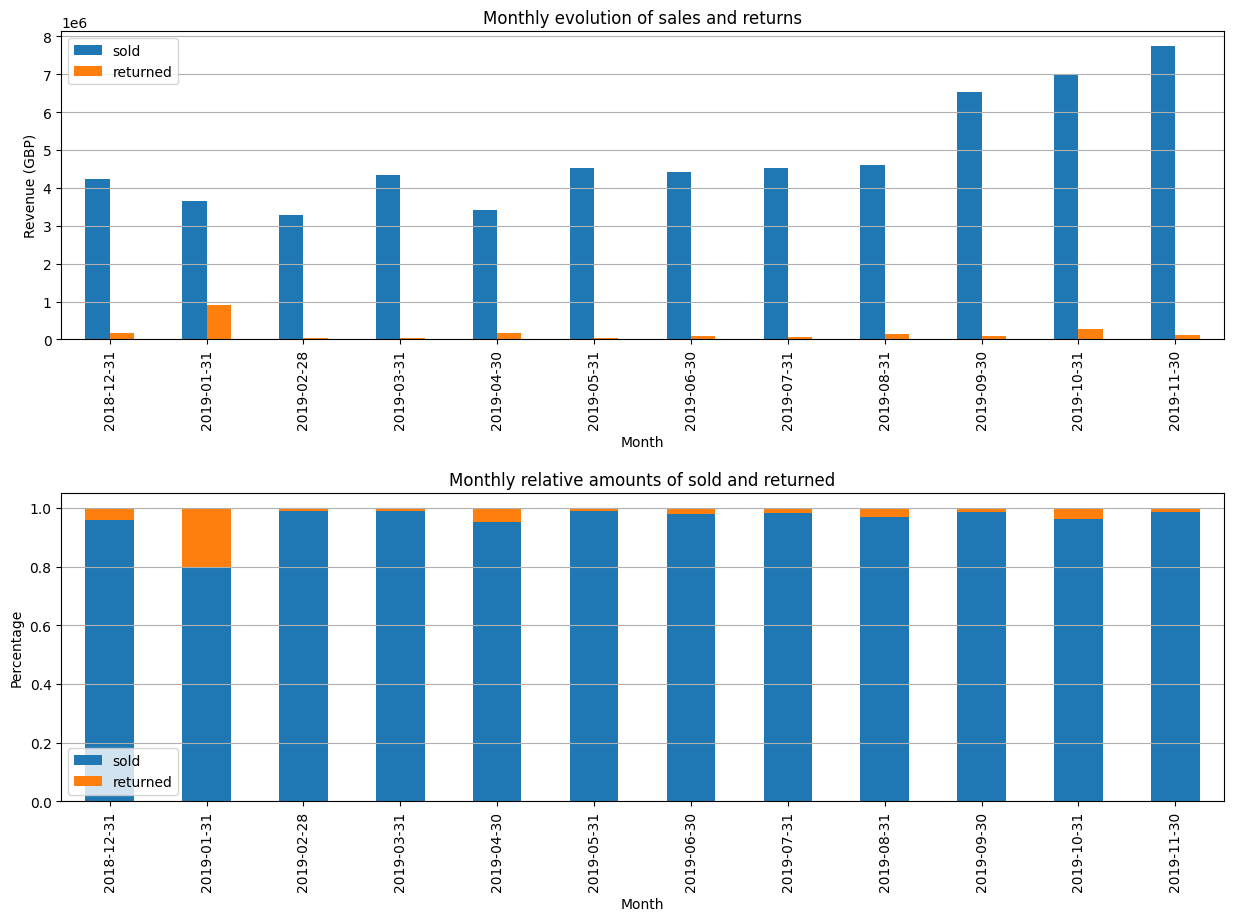

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
month_evo[['sold', 'returned']].plot.bar(ax=ax[0])
ax[0].set_ylabel('Revenue (GBP)')
ax[0].set_xlabel('Month')
ax[0].set_title("Monthly evolution of sales and returns")
ax[0].grid(axis='y')

month_evo_pct.plot.bar(stacked=True, ax=ax[1])
ax[1].set_ylabel('Percentage')
ax[1].set_xlabel('Month')
ax[1].set_title("Monthly relative amounts of sold and returned")
ax[1].grid(axis='y')

plt.subplots_adjust(hspace=0.5)
plt.show()

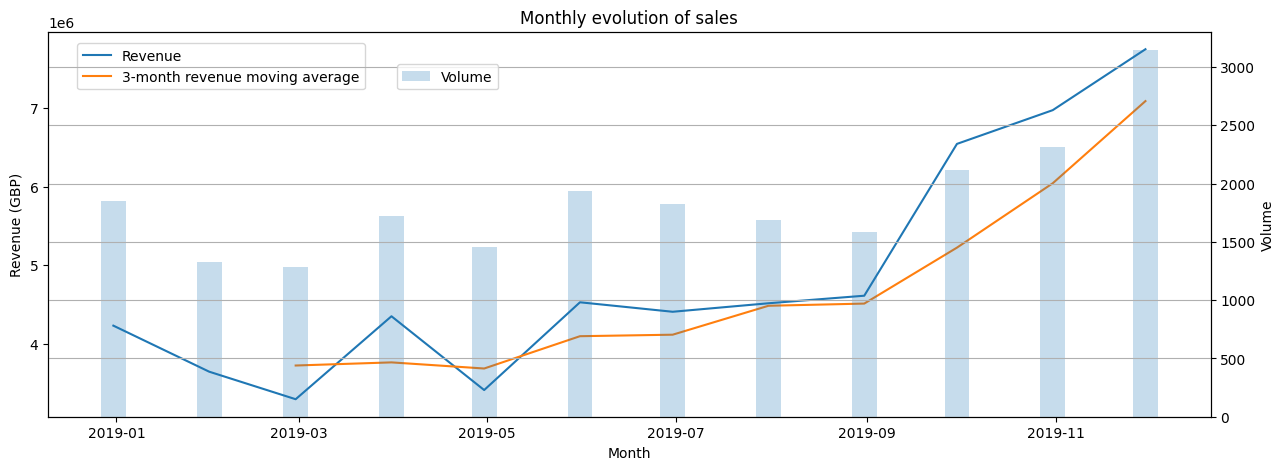

In [50]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = plt.twinx()
ax1.plot(month_evo.index, month_evo['sold'], label='Revenue')
ax1.plot(month_evo.index, month_evo['sold_moving_avg'], label='3-month revenue moving average')
ax2.bar(month_evo.index, month_evo['nunique'], width=8, label='Volume', alpha=0.25)

ax1.set_ylabel('Revenue (GBP)')
ax2.set_ylabel('Volume')
ax1.set_xlabel('Month')
plt.title("Monthly evolution of sales")
plt.grid(True)
ax1.legend(loc=(0.025,0.85))
ax2.legend(loc=(0.3,0.85))

plt.show()

## Intra-month analysis

In [51]:
df = df[df['Quantity'] > 0]

bydate = df.groupby('Date').agg(
    UniqueTransactions=('TransactionNo', 'nunique'),
    UniqueProdSold=('TransactionNo', 'count'),
    ProdSold=('Quantity', 'sum'),
    Revenue=('Amount', 'sum')
    ).reset_index()
bydate['Day'] = bydate['Date'].dt.day
bydate['Weekday'] = bydate['Date'].dt.weekday
bydate['Month'] = bydate['Date'].dt.month

bydate['WeekdayName'] = bydate['Date'].dt.day_name()
bydate

,Date,UniqueTransactions,UniqueProdSold,ProdSold,Revenue,Day,Weekday,Month,WeekdayName
0,2018-12-01,127,3061,26889,326820.08,1,5,12,Saturday
1,2018-12-02,141,2057,31297,367316.62,2,6,12,Sunday
2,2018-12-03,68,2136,16164,206313.62,3,0,12,Monday
3,2018-12-05,88,2694,16357,197565.27,5,2,12,Wednesday
4,2018-12-06,103,3823,21867,273420.10,6,3,12,Thursday
...,...,...,...,...,...,...,...,...,...
292,2019-11-25,84,3073,31504,197883.43,25,0,11,Monday
293,2019-11-27,57,2529,11151,71166.89,27,2,11,Wednesday
294,2019-11-28,114,3293,29440,190534.34,28,3,11,Thursday
295,2019-11-29,135,4275,30872,200962.48,29,4,11,Friday


In [52]:
byday = bydate.groupby('Day')[['UniqueTransactions', 'UniqueProdSold', 'ProdSold', 'Revenue']].mean()
byday.columns = ['DailyAvgUniqueTransactions', 'DailyAvgUniqueProdSold', 'DailyAvgProdSold', 'DailyAvgRev']
byday = byday.sort_index()
byday.head()

,DailyAvgUniqueTransactions,DailyAvgUniqueProdSold,DailyAvgProdSold,DailyAvgRev
Day,,,,
1,62.200,1425.600000,15170.000000,176053.439000
2,66.875,1685.625000,16904.750000,197402.811250
3,54.700,1410.100000,15707.800000,188742.753000
4,61.400,1713.100000,19456.500000,226897.317000
5,71.000,1815.111111,20756.666667,238868.772222


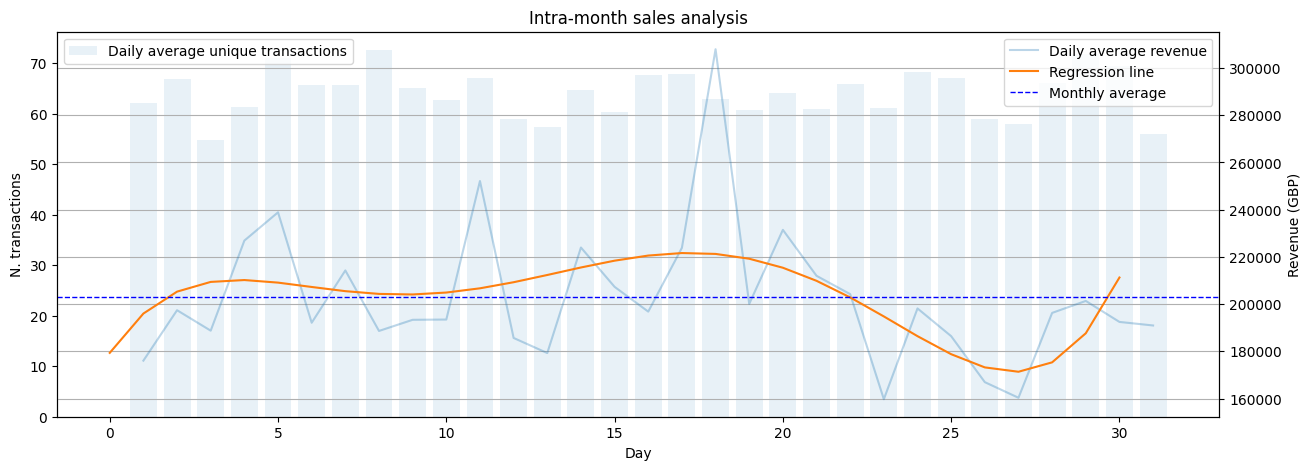

In [53]:
rev_coefficients = np.polyfit(byday.index.values, byday['DailyAvgRev'].values, 5)
rev_regression_line = np.poly1d(rev_coefficients)

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = plt.twinx()
ax2.plot(byday.index, byday['DailyAvgRev'], label='Daily average revenue', alpha=0.3)
ax1.bar(byday.index, byday['DailyAvgUniqueTransactions'], label='Daily average unique transactions', alpha=0.1)
ax2.plot(rev_regression_line(byday.index.values), label='Regression line')
ax2.axhline(byday['DailyAvgRev'].mean(), color='b', linestyle='dashed', linewidth=1, label='Monthly average')

ax1.set_ylabel('N. transactions')
ax2.set_ylabel('Revenue (GBP)')
plt.title("Intra-month sales analysis")
plt.grid(True)
ax1.legend(loc='upper left')
ax1.set_xlabel('Day')
ax2.legend()

plt.show()

By analyzing the revenue data within a month, we can observe that the daily average revenue varies throughout the month. The revenue reaches its peak at around three-quarters of the month and dips to its lowest point just before the end of the month. However, it starts to increase again just before the last few days. The dip in revenue just before the end of the month is considered normal as it coincides with the time when people typically receive their salaries.

## Intra-week analysis

In [54]:
byweekday = bydate.groupby(['Weekday', 'WeekdayName'])[['UniqueTransactions', 'UniqueProdSold', 'ProdSold', 'Revenue']].mean()
byweekday.columns = ['DailyAvgUniqueTransactions', 'DailyAvgUniqueProdSold', 'DailyAvgProdSold', 'DailyAvgRev']
byweekday = byweekday.reset_index().set_index('Weekday')
byweekday.index = byweekday.index + 1
byweekday

,WeekdayName,DailyAvgUniqueTransactions,DailyAvgUniqueProdSold,DailyAvgProdSold,DailyAvgRev
Weekday,,,,,
1,Monday,61.416667,1570.854167,16290.958333,187875.265208
3,Wednesday,43.612245,1259.551020,9342.183673,107400.393061
4,Thursday,64.217391,1900.000000,17979.391304,208483.595435
5,Friday,66.705882,1879.764706,21235.274510,245216.874706
6,Saturday,68.500000,1721.365385,18900.384615,210759.228077
7,Sunday,77.843137,1820.686275,22464.431373,257149.160980


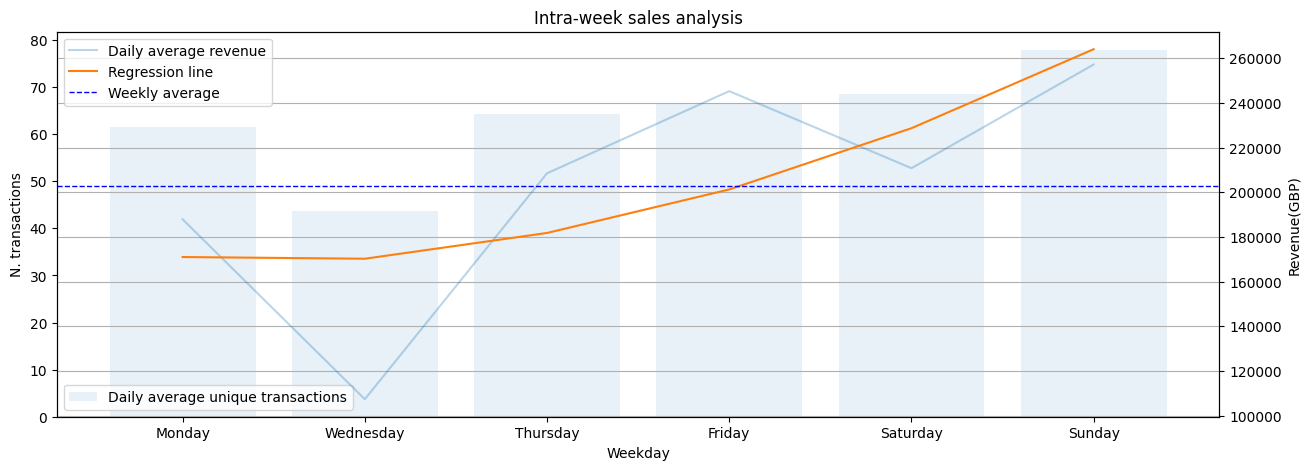

In [55]:
rev_coefficients = np.polyfit(byweekday.index.values, byweekday['DailyAvgRev'].values, 2)
rev_regression_line = np.poly1d(rev_coefficients)

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = plt.twinx()
ax2.plot(byweekday['WeekdayName'], byweekday['DailyAvgRev'], label='Daily average revenue', alpha=0.3)
ax1.bar(byweekday['WeekdayName'], byweekday['DailyAvgUniqueTransactions'], label='Daily average unique transactions', alpha=0.1)
ax2.plot(rev_regression_line(byweekday.index.values), label='Regression line')
ax2.axhline(byweekday['DailyAvgRev'].mean(), color='b', linestyle='dashed', linewidth=1, label='Weekly average')

ax1.set_ylabel('N. transactions')
ax2.set_ylabel('Revenue(GBP)')
plt.title("Intra-week sales analysis")
plt.grid(axis='y')
ax1.legend(loc='lower left')
ax1.set_xlabel('Weekday')
ax2.legend()

plt.show()

## Geographical analysis

When conducting a geographical analysis of sales, it is essential to consider both the average purchase value and sales volume to determine if there are any countries that offer promising opportunities. For instance, a country with a high average purchase value but low sales volume may indicate that it has untapped potential and should be targeted for further penetration. The average purchase value gives an indication of the buying power and willingness of customers to spend money, while sales volume reflects the market demand and potential for growth. A country with a high average purchase value and low sales volume could be a potential opportunity for businesses to capitalize on the untapped market potential by increasing their presence and promoting their products or services more effectively.

In [56]:
# Mapping regions
regions = {'Europe': ['Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland', 'Netherlands', 'Belgium', 'France', 'Germany', 'Switzerland', 'Austria',
                      'Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Czech Republic', 'Lithuania', 'Poland', 'United Kingdom', 'EIRE',
                      'Channel Islands', 'European Community'],
           'North America': ['USA', 'Canada'],
           'Middle East': ['Bahrain', 'United Arab Emirates', 'Israel', 'Lebanon', 'Saudi Arabia'],
           'Asia Pacific': ['Japan', 'Australia', 'Singapore', 'Hong Kong'],
           'RoW': ['Brazil', 'RSA'],
           'Unspecified': ['Unspecified']}

country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

df['Region'] = df['Country'].map(country_to_region)

df['UKvsRoW'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'RoW')

In [57]:
bycountry = df.groupby('Country').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean')
).sort_values('tot_amount', ascending=False)
bycountry.head()

,tot_amount,mean_amount
Country,,
United Kingdom,50192562.28,110.502027
Netherlands,2101104.07,937.992888
EIRE,1687318.68,225.607525
Germany,1346540.40,135.494103
France,1306661.68,129.564867


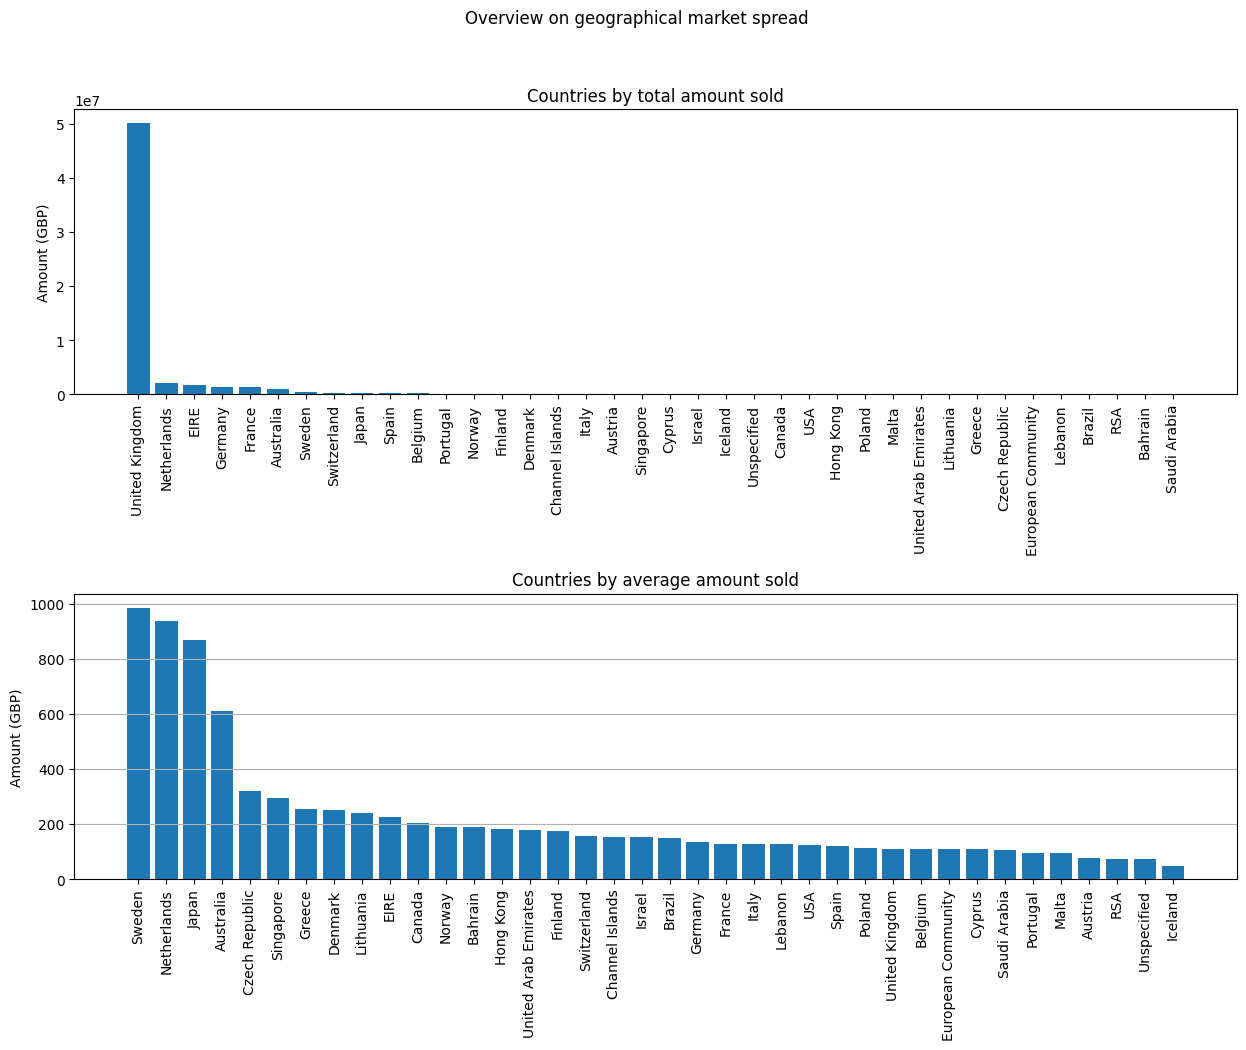

In [58]:
fig, ax = plt.subplots(2, figsize=(15,10))
ax[0].bar(bycountry.index, bycountry['tot_amount'])
ax[1].bar(bycountry.sort_values('mean_amount', ascending=False).index, bycountry.sort_values('mean_amount', ascending=False)['mean_amount'])
plt.setp(ax, xticks=bycountry.index, xticklabels=bycountry.index)
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="center")
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="center")

ax[0].set_ylabel("Amount (GBP)")
ax[1].set_ylabel("Amount (GBP)")
ax[0].set_title("Countries by total amount sold")
ax[1].set_title("Countries by average amount sold")
plt.suptitle("Overview on geographical market spread")
plt.grid(axis='y')
plt.subplots_adjust(hspace=0.7)

plt.show()

In [59]:
byukvsrow = df.groupby('UKvsRoW').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean'),
    n_inv=('TransactionNo', 'nunique'),
    quantity=('Quantity', 'mean')
).sort_values('mean_amount', ascending=False)
byukvsrow

,tot_amount,mean_amount,n_inv,quantity
UKvsRoW,,,,
RoW,10258462.78,211.383944,1809,18.478900
UK,50192562.28,110.502027,17164,9.646163


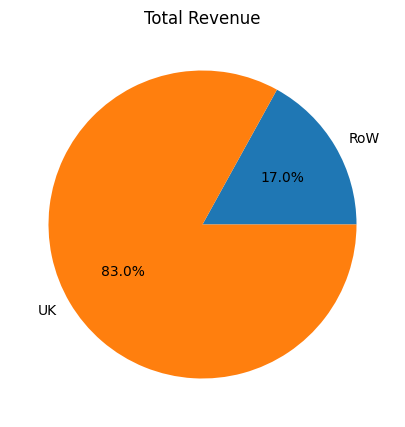

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
ax = plt.pie(byukvsrow['tot_amount'], labels=byukvsrow.index, autopct='%1.1f%%')
plt.title('Total Revenue')
plt.show()

In [61]:
row_rev = df.loc[df['UKvsRoW'] == 'RoW', 'Amount']
uk_rev = df.loc[df['UKvsRoW'] == 'UK', 'Amount']

ttest_ind(uk_rev, row_rev)

Ttest_indResult(statistic=-16.7279858606087, pvalue=8.524026769071223e-63)

> Even though the volume of sales of international customers accounts only for the 17.0%, the **average revenue generated abroad is statistically higher than the one generated in the UK**. This means that international markets for our business are potentially more lucrative than the national one and need to be exploited more.

In [62]:
byregion = df.groupby('Region').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean'),
    n_inv=('TransactionNo', 'nunique'),
    quantity=('Quantity', 'mean')
).sort_values('mean_amount', ascending=False)
byregion.sort_values('mean_amount', ascending=False)

,tot_amount,mean_amount,n_inv,quantity
Region,,,,
Asia Pacific,1380079.80,590.787586,92,51.083904
North America,59633.28,154.891636,11,13.503896
Middle East,76798.30,154.835282,16,12.661290
Europe,58892902.53,118.021612,18839,10.308538
RoW,8912.10,101.273864,2,8.000000
Unspecified,32699.05,73.152237,13,6.272931


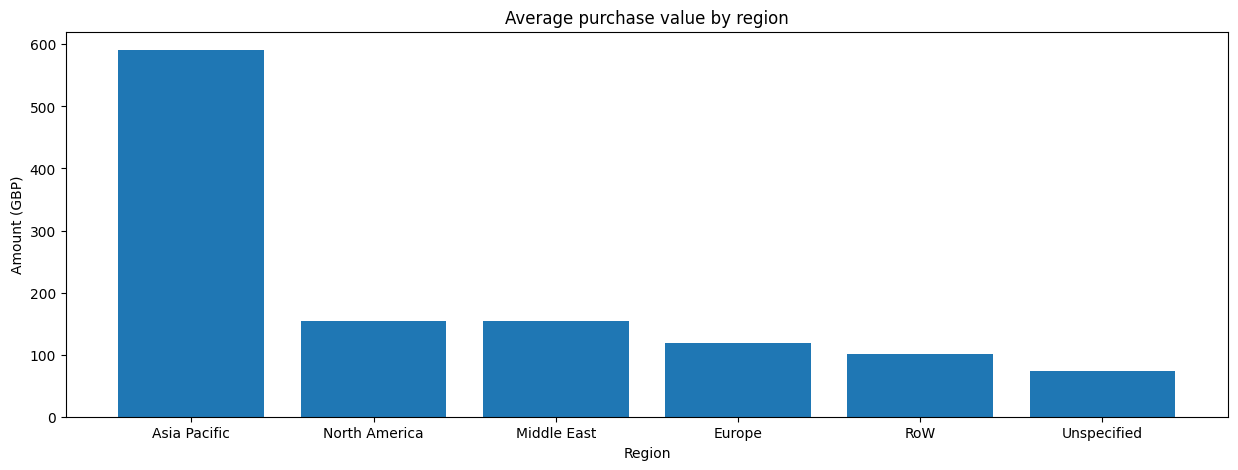

In [63]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax1 = plt.bar(byregion.index, byregion['mean_amount'])
plt.title("Average purchase value by region")
plt.ylabel('Amount (GBP)')
plt.xlabel('Region')
plt.show()

In [64]:
f_value, p_value = f_oneway(df.loc[df['Region'] == 'Asia Pacific', 'Amount'],
                            df.loc[df['Region'] == 'North America', 'Amount'],
                            df.loc[df['Region'] == 'Middle East', 'Amount'],
                            df.loc[df['Region'] == 'Europe', 'Amount'],
                            df.loc[df['Region'] == 'RoW', 'Amount'])
print(f'ANOVA F-value: {f_value:.2f}')
print(f'ANOVA p-value: {p_value:.4f}')
tukey_df = df.filter(items=['Amount', 'Region']).dropna()
print(pairwise_tukeyhsd(tukey_df['Amount'], tukey_df['Region']))

ANOVA F-value: 81.58
ANOVA p-value: 0.0000
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
 Asia Pacific        Europe  -472.766    0.0 -547.3921 -398.1398   True
 Asia Pacific   Middle East -435.9523    0.0  -613.855 -258.0496   True
 Asia Pacific North America -435.8959    0.0 -633.8256 -237.9663   True
 Asia Pacific           RoW -489.5137 0.0048 -880.2663  -98.7612   True
 Asia Pacific   Unspecified -517.6353    0.0 -703.4071 -331.8636   True
       Europe   Middle East   36.8137 0.9872  -124.841  198.4683  False
       Europe North America     36.87 0.9928 -146.5938  220.3338  False
       Europe           RoW  -16.7477    1.0 -400.3757  366.8802  False
       Europe   Unspecified  -44.8694 0.9754 -215.1456  125.4068  False
  Middle East North America    0.0564    1.0 -244.3599  244.4726  False
  Middle East        

> We can observe from both the bar plot and the ANOVA analysis that the **mean purchase value in the Asia/Pacific region is consistently and significantly greater** than the mean purchase value in the other regions. Based on this important information, we can infer that the Asia/Pacific region is a potentially lucrative market with higher average purchase amounts than the other regions. Therefore, the store may want to consider investing more resources in this region to take advantage of this opportunity to increase volume of sales. The business can consider implementing targeted marketing strategies, such as advertising campaigns and promotions, that cater to the preferences and interests of the Asia/Pacific market. Additionally, it can explore expanding its product offerings to meet the specific demands of this region, or enhancing the quality of existing products to meet their higher standards. It may be useful to conduct further research and analysis to gain deeper insights into the preferences and behavior of customers in the Asia/Pacific region, and tailor sales strategies accordingly.

# Market basket analysis

In [65]:
products = df[['ProductNo', 'ProductName']].drop_duplicates()

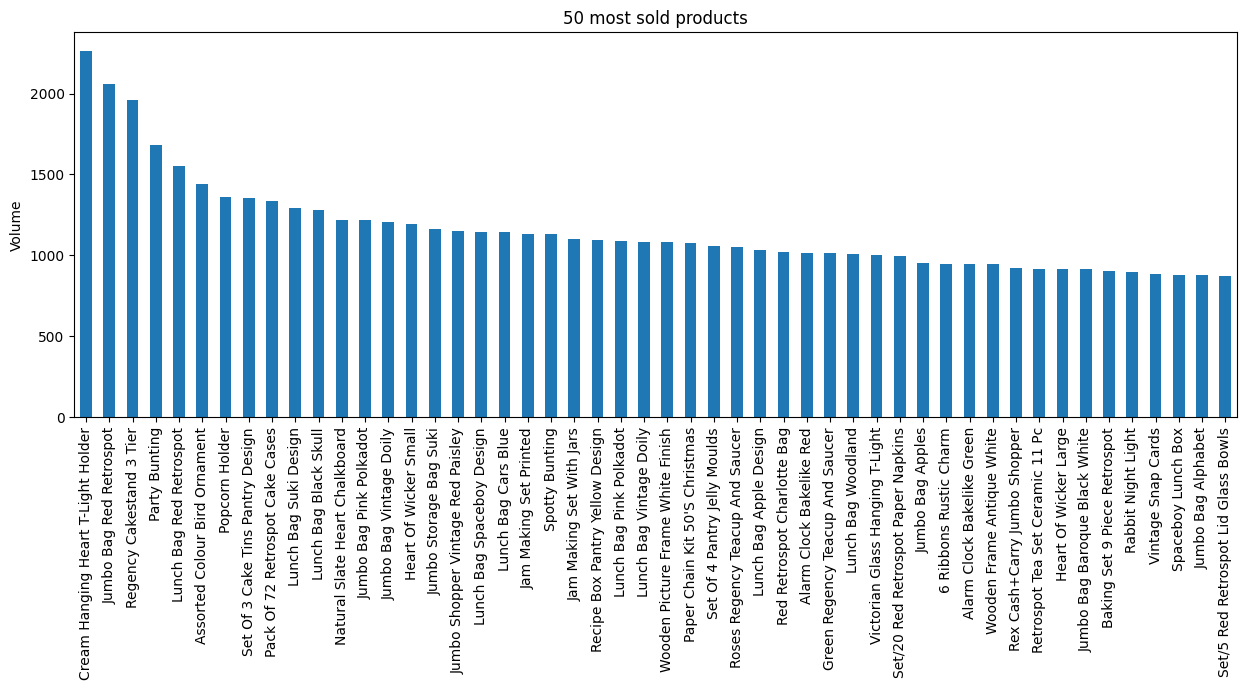

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
df['ProductName'].value_counts().head(50).plot(kind='bar', ax=ax)
plt.title("50 most sold products")
plt.ylabel('Volume')
plt.show()